# Projet IASD 2024
## Analyse des attaques adversariales
------------------------------------------------------------------

Ce projet vise à analyser les performances de modèles de machine learning soumis à des attaques adversarial. Les attaques, comme PGD et FGSM, perturbent les données d'entrée pour tester la robustesse des modèles. **L'objectif est de comprendre comment ces modèles réagissent face à différentes attaques et d'identifier les configurations les plus robustes.**

Deux modèles sont utilisés dans cette étude :
- **Modèle classique** : modèle convolutionnel standard conçu pour effectuer des tâches de classification d’images. Il comprend deux couches de convolution suivies de couches de pooling et de trois couches entièrement connectées.
- **Modèle Lipschitz** : le modèle reprend l’architecture de Modèle classique, mais impose une contrainte de Lipschitz pour améliorer la stabilité et la robustesse du modèle, notamment en réduisant les variations extrêmes dans les sorties par rapport aux variations des entrées.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.cm as cm
import numpy as np
import os

In [30]:
##################################################################################
# Functions
##################################################################################

# Function to load attack results
def load_attack_results(directory):
    all_data = {}
    # Recursively find all JSON files in the directory and subdirectories
    json_files = glob(os.path.join(directory, '**', '*.json'), recursive=True)

    for file in json_files:
        with open(file, 'r') as f:
            data = json.load(f)
            for result in data:
                if isinstance(result, dict):  # Ensure result is a dictionary
                    attack_type = result.get('type', 'unknown')
                    all_data[attack_type] = {
                        'train_losses': result.get('train_losses', []),
                        'train_accuracies': result.get('train_accuracies', []),
                        'test_accuracy': result.get('test_accuracies', [0])[0],
                        'test_precision': result.get('test_precisions', [0])[0],
                        'test_recall': result.get('test_recall', [0])[0],
                        'test_f1_score': result.get('test_f1_scores', [0])[0]
                    }
    return all_data

# Function to load execution times
def load_execution_times(directory):
    exec_times = {}
    # Recursively find all JSON files in the directory and subdirectories
    json_files = glob(os.path.join(directory, '**', '*.json'), recursive=True)

    for file in json_files:
        with open(file, 'r') as f:
            try:
                data = json.load(f)
                if isinstance(data, dict):  # Ensure data is a dictionary
                    exec_times.update(data)
                else:
                    print(f"Warning: {file} does not contain a dictionary. Data type: {type(data)}")
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from {file}: {e}")
    return exec_times

# Function to plot losses and accuracies for all models and attacks
def plot_learning_curves(data):
    plt.figure(figsize=(18, 8))  # size of the figure
    
    # Unique color for each attack
    colors = cm.tab10.colors 
    color_map = {attack_type: colors[i % len(colors)] for i, attack_type in enumerate(data.keys())}

    # Loss curve - all attacks on the same plot
    plt.subplot(1, 2, 1)
    for attack_type, values in data.items():
        plt.plot(values['train_losses'], label=f'{attack_type} Loss', color=color_map[attack_type], linestyle='-', linewidth=1.5)
    plt.title('Loss Curves for All Attacks', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Accuracy curve - all attacks on the same plot
    plt.subplot(1, 2, 2)
    for attack_type, values in data.items():
        plt.plot(values['train_accuracies'], label=f'{attack_type} Accuracy', color=color_map[attack_type], linestyle='-', linewidth=1.5)
    plt.title('Accuracy Curves for All Attacks', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Legend outside the plots
    plt.subplots_adjust(right=0.8) 
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, frameon=True, fancybox=True, shadow=True, title="Attack Types")
    
    plt.tight_layout(pad=3.0)  # Space between subplots
    plt.show()

# Function to plot attacks and comparison
def plot_learning_comparison(data, main_attack, compare_with='normal', optional_attack=None):
    plt.figure(figsize=(18, 8))  
    
    # Unique color for each attack
    colors = cm.tab10.colors 
    color_map = {attack_type: colors[i % len(colors)] for i, attack_type in enumerate(data.keys())}
    
    # Filter the attacks to plot
    attacks_to_plot = [main_attack, compare_with]
    if optional_attack:
        attacks_to_plot.append(optional_attack)
    
    # Loss curve - all selected curves on the same plot
    plt.subplot(1, 2, 1)
    for attack_type in attacks_to_plot:
        values = data.get(attack_type, {})
        if values: 
            plt.plot(values['train_losses'], label=f'{attack_type} Loss', color=color_map[attack_type], linestyle='-', linewidth=1.5)
    plt.title(f'Loss Curves Comparison: {main_attack}', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Accuracy curve - all selected curves on the same plot
    plt.subplot(1, 2, 2)
    for attack_type in attacks_to_plot:
        values = data.get(attack_type, {})
        if values:
            plt.plot(values['train_accuracies'], label=f'{attack_type} Accuracy', color=color_map[attack_type], linestyle='--', linewidth=1.5)
    plt.title(f'Accuracy Curves Comparison: {main_attack}', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)

    # legend outside the plots
    plt.subplots_adjust(right=0.8)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, frameon=True, fancybox=True, shadow=True, title="Comparison Curves")
    
    plt.tight_layout(pad=3.0) 
    plt.show()

# Function for metrics and plotting accuracies
def summary_metrics_with_accuracy_plot(data):
    metrics_df = pd.DataFrame({
        'Attack Type': list(data.keys()),
        'Test Accuracy': [v['test_accuracy'] for v in data.values()],
        'Test Precision': [v['test_precision'] for v in data.values()],
        'Test Recall': [v['test_recall'] for v in data.values()],
        'Test F1 Score': [v['test_f1_score'] for v in data.values()],
    })
    
    print(metrics_df)
    
    # Plotting of accuracies
    colors = cm.tab10.colors[:len(metrics_df)] # Color for each attack
    plt.figure(figsize=(14, 8))
    bars = plt.bar(metrics_df['Attack Type'], metrics_df['Test Accuracy'], color=colors)
    
    # Add annotations to display accuracy values on each bar
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, 
                 f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='white')

    # Title and labels
    plt.title('Test Accuracy Comparison by Attack Type', fontsize=16, fontweight='bold')
    plt.xlabel('Attack Type', fontsize=14)
    plt.ylabel('Test Accuracy', fontsize=14)
    plt.ylim(0, 1) 
    plt.xticks(rotation=45, ha='right')  # 45 degree rotation for better readability
    plt.grid(axis='y', linestyle='--', linewidth=0.5)

    plt.show()

# Function to plot execution time
def plot_execution_times(exec_times):
    exec_df = pd.DataFrame(list(exec_times.items()), columns=['Attack Type', 'Execution Time'])
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(exec_df['Attack Type'], exec_df['Execution Time'], color='skyblue')
    
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 20, 
                 f'{bar.get_height():.2f} s', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
    
    # Title and labels
    plt.title('Execution Time by Attack Type', fontsize=14, fontweight='bold')
    plt.xlabel('Attack Type', fontsize=12)
    plt.ylabel('Execution Time (seconds)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.show()

# Function to calculate the efficiency of attack on accuracies and time
def analyze_efficiency(data, exec_times):
    
    metrics_df = pd.DataFrame({
        'Attack Type': list(data.keys()),
        'Test Accuracy': [v['test_accuracy'] for v in data.values()],
        'Execution Time': [exec_times.get(attack, None) for attack in data.keys()]
    }).dropna()
    
    # Calculate the Efficiency Ratio (Accuracy / Time)
    #metrics_df['Efficiency Ratio (Accuracy/Time)'] = metrics_df['Test Accuracy'] / metrics_df['Execution Time']
    metrics_df['Efficiency Ratio (1-Accuracy)/Time'] = (1 - metrics_df['Test Accuracy']) / metrics_df['Execution Time']
    print(metrics_df)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(metrics_df['Attack Type'], metrics_df['Efficiency Ratio (1-Accuracy)/Time'], color='lightcoral')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.5f}', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title('Efficiency of Attacks ((1-Accuracy)/Execution Time)', fontsize=14, fontweight='bold')
    plt.xlabel('Attack Type', fontsize=12)
    plt.ylabel('Efficiency Ratio (Accuracy/Time)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.show()

# Function to analyze the impact of epsilon on accuracy and execution time
def analyze_epsilon_impact(data, exec_times):
    
    # Extract FGSM attacks only
    fgsm_data = {k: v for k, v in data.items() if 'fgsm' in k}
    fgsm_exec_times = {k: exec_times[k] for k in fgsm_data.keys()}

    epsilon_values = [float(k.split('_')[-1]) for k in fgsm_data.keys()] 
    epsilon_df = pd.DataFrame({
        'Epsilon': epsilon_values,
        'Test Accuracy': [v['test_accuracy'] for v in fgsm_data.values()],
        'Execution Time': list(fgsm_exec_times.values())
    }).sort_values('Epsilon')  

    print(epsilon_df)
    
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Epsilon')
    ax1.set_ylabel('Test Accuracy', color='tab:blue')
    ax1.plot(epsilon_df['Epsilon'], epsilon_df['Test Accuracy'], color='tab:blue', marker='o', label='Test Accuracy')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx() 
    ax2.set_ylabel('Execution Time (seconds)', color='tab:red')
    ax2.plot(epsilon_df['Epsilon'], epsilon_df['Execution Time'], color='tab:red', marker='x', linestyle='--', label='Execution Time')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Impact of Epsilon on Accuracy and Execution Time (FGSM)')
    fig.tight_layout()
    plt.show()

# Function to create a DataFrame with epsilon values and test accuracies
def create_epsilon_df(data, exec_times):

    epsilon_values = []
    test_accuracies = []
    execution_times = []
    
    # Load the data to extract FGSM attacks
    for attack_type, metrics in data.items():
        if 'fgsm' in attack_type:
            epsilon = float(attack_type.split('_')[-1])
            epsilon_values.append(epsilon)
            test_accuracies.append(metrics['test_accuracy'])
            execution_times.append(exec_times.get(attack_type, None)) 

    epsilon_df = pd.DataFrame({
        'Epsilon': epsilon_values,
        'Test Accuracy': test_accuracies,
        'Execution Time': execution_times
    }).dropna() 

    return epsilon_df

# Function to analyze the correlation between epsilon and execution time
def analyze_correlation(epsilon_df):
    correlation = np.corrcoef(epsilon_df['Epsilon'], epsilon_df['Execution Time'])[0, 1]
    print(f'Correlation between Epsilon and Execution Time: {correlation:.2f}')

# Function to plot the correlation between epsilon and execution time
def plot_accuracy_vs_execution_time(data, exec_times):

    # Convert data to DataFrame
    df = pd.DataFrame({
        'Attack Type': list(data.keys()),
        'Test Accuracy': [v['test_accuracy'] for v in data.values()],
        'Execution Time': [exec_times.get(attack, None) for attack in data.keys()]
    }).dropna()

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    for i, row in df.iterrows():
        plt.scatter(row['Execution Time'], row['Test Accuracy'], label=row['Attack Type'], s=100)

    # Add annotations
    for i, row in df.iterrows():
        plt.text(row['Execution Time'] + 20, row['Test Accuracy'], row['Attack Type'], fontsize=9)

    # Add labels, title, and grid
    plt.xlabel("Execution Time (ms)", fontsize=12)
    plt.ylabel("Test Accuracy", fontsize=12)
    plt.title("Tradeoff Between Test Accuracy and Execution Time", fontsize=14)
    plt.grid(True)
    plt.legend(loc="upper right", fontsize=8)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Function to compare models based on accuracy and execution time
def compare_models_accuracy_execution_time(classic_data, lipschitz_data):
    # Create DataFrames for both models
    classic_df = pd.DataFrame({
        'Attack Type': list(classic_data.keys()),
        'Test Accuracy': [v['test_accuracy'] for v in classic_data.values()]
    }).dropna()

    lipschitz_df = pd.DataFrame({
        'Attack Type': list(lipschitz_data.keys()),
        'Test Accuracy': [v['test_accuracy'] for v in lipschitz_data.values()]
    }).dropna()

    bar_width = 0.35  # Width of the bars
    attack_types = classic_df['Attack Type']
    index = range(len(attack_types))

    # Plot comparison of accuracies
    plt.figure(figsize=(14, 6))

    plt.bar(index, classic_df['Test Accuracy'], bar_width, label='Classic Model', color='blue', alpha=0.6)
    plt.bar([i + bar_width for i in index], lipschitz_df['Test Accuracy'], bar_width, label='Lipschitz Model', color='red', alpha=0.6)
    plt.title('Test Accuracy Comparison')
    plt.xlabel('Attack Type')
    plt.ylabel('Test Accuracy')
    plt.xticks([i + bar_width / 2 for i in index], attack_types, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

# Analyse des différentes attaques adversariales

Les différentes attaques mises en pratiques dans ce projet sont: 

### PGD (Projected Gradient Descent)

L’attaque PGD (Projected Gradient Descent) utilise une descente de gradients itérative pour maximiser la perte du modèle tout en limitant la perturbation à une certaine distance, contrôlée par le
paramètre epsilon. PGD commence par une petite perturbation initiale, puis ajuste cette perturbation itérativement pour maximiser la perte. À chaque itération, PGD utilise le gradient de la fonction de
perte par rapport à l’entrée pour décider de la direction dans laquelle les pixels ou les features doivent être perturbés. Après chaque mise à jour, la perturbation est “projetée” dans la plage de valeurs autorisée définie par epsilon, ce qui garantit que l’attaque reste dans un certain rayon autour de l’image d’origine. Cette projection est la clé de l’attaque PGD, car elle assure que la perturbation reste limitée à une norme spécifique (typiquement la norme L_Infinie ou L_2).

*Paramètres utilisés* :
  - epsilon : La magnitude maximale de la perturbation appliquée à chaque pixel. Plus epsilon est élevé, plus la perturbation est importante.
  - alpha : Le pas de mise à jour à chaque itération. Un alpha plus grand accélère la convergence mais peut entraîner une perturbation moins précise.
  - num_iter : Le nombre d’itérations de descente de gradients. Un nombre d’itérations élevé permet d’obtenir une perturbation plus optimisée mais allonge le temps d’exécution.

### FGSM (Fast Gradient Sign Method)

L’attaque FGSM est une méthode simple introduite pour générer rapidement des exemples adversariaux en appliquant une perturbation en une seule étape.

FGSM fonctionne en ajoutant une petite perturbation à chaque pixel dans la direction du gradient de la fonction de perte par rapport à l’entrée. Cela signifie que chaque pixel est modifié dans la direction qui augmente le plus la perte du modèle, ce qui maximise les chances de tromper le modèle. L’attaque est définie par une seule étape de mise à jour, ce qui la rend rapide et peu coûteuse en termes de
calcul.

*Paramètres utilisés* :
   - epsilon : Ce paramètre contrôle l’intensité de la perturbation. Un epsilon plus élevé signifie une attaque plus agressive, mais aussi plus visible (les perturbations sont plus grandes).

---------------------------------------------------------------
## Analyse des attaques sur le modèle classique

Il a été comparé les performances des différentes attaques sur le modèle classique. Les courbes d'apprentissage montrent l'évolution des pertes et des précisions. Cette comparaison met en évidence la vulnérabilité des modèles face à des attaques spécifiques et identifie celles qui causent les plus grandes pertes de précision.

Le modèle atteint ses meilleures performances sur des données non-attaquées avec une accuracy de 68,44% et un F1-score de 68,48% . Cela montre que le modèle fonctionne bien sans perturbations adversariales. En revanche, les performances du modèle chutent considérablement en présence d’attaques adversariales :


| Attack Type      | Accuracy | Precision | Recall | F1 Score |
|------------------|----------|-----------|--------|----------|
| pgd\_l2\_eps\_0.1 | 41.32%   | 44.65%    | 41.32% | 42.35%   |
| pgd\_l2\_eps\_0.2 | 38.15%   | 39.10%    | 38.15% | 38.27%   |
| pgd\_l2\_eps\_0.3 | 32.23%   | 33.67%    | 32.23% | 32.44%   |
| fgsm\_eps\_0.02   | 29.24%   | 29.55%    | 29.24% | 29.07%   |
| fgsm\_eps\_0.04   | 17.79%   | 16.68%    | 17.79% | 17.07%   |
| fgsm\_eps\_0.06   | 19.74%   | 17.70%    | 19.74% | 17.97%   |
| normal           | 68.44%   | 68.65%    | 68.44% | 68.48%   |
| pgd\_eps\_0.1     | 20.41%   | 22.44%    | 20.41% | 20.06%   |
| pgd\_eps\_0.2     | 20.93%   | 21.01%    | 20.93% | 20.84%   |
| pgd\_eps\_0.4     | 19.64%   | 19.06%    | 19.64% | 19.17%   |

Plus précisement,
- PGD-L2 : Avec une augmentation de l’epsilon, les performances se détériorent (accuracy de 41,32% pour un epsilon de 0.1 à 32,23% pour un epsilon de 0.3). Cela indique une sensibilité croissante aux perturbations.
- FGSM : Cette attaque entraîne une dégradation encore plus marquée, surtout avec un epsilon élevé (accuracy de 29,24% pour un epsilon de 0.02 à 17,79% pour epsilon=0.04). Dans ce drnier cas, la chute de l'accucary est de 74% par rapport à la performance du modèle classique. FGSM avec un epsilon de 0.04 montre les performances les plus faibles sur toutes les métriques, avec un F1-score de seulement 17,07%.

En conclusion, les attaques peuvent être classées dans l'ordre suivant en terme d'efficacité :
1. FGSM (epsilon=0.04) : la plus destructrice.
2. FGSM (epsilon=0.06) : impact également très élevé.
3. PGD (epsilon=0.4) : légèrement moins efficace, mais toujours destructrice.
4. PGD-L2 (epsilon=0.3) : effet important, mais plus modéré que FGSM.

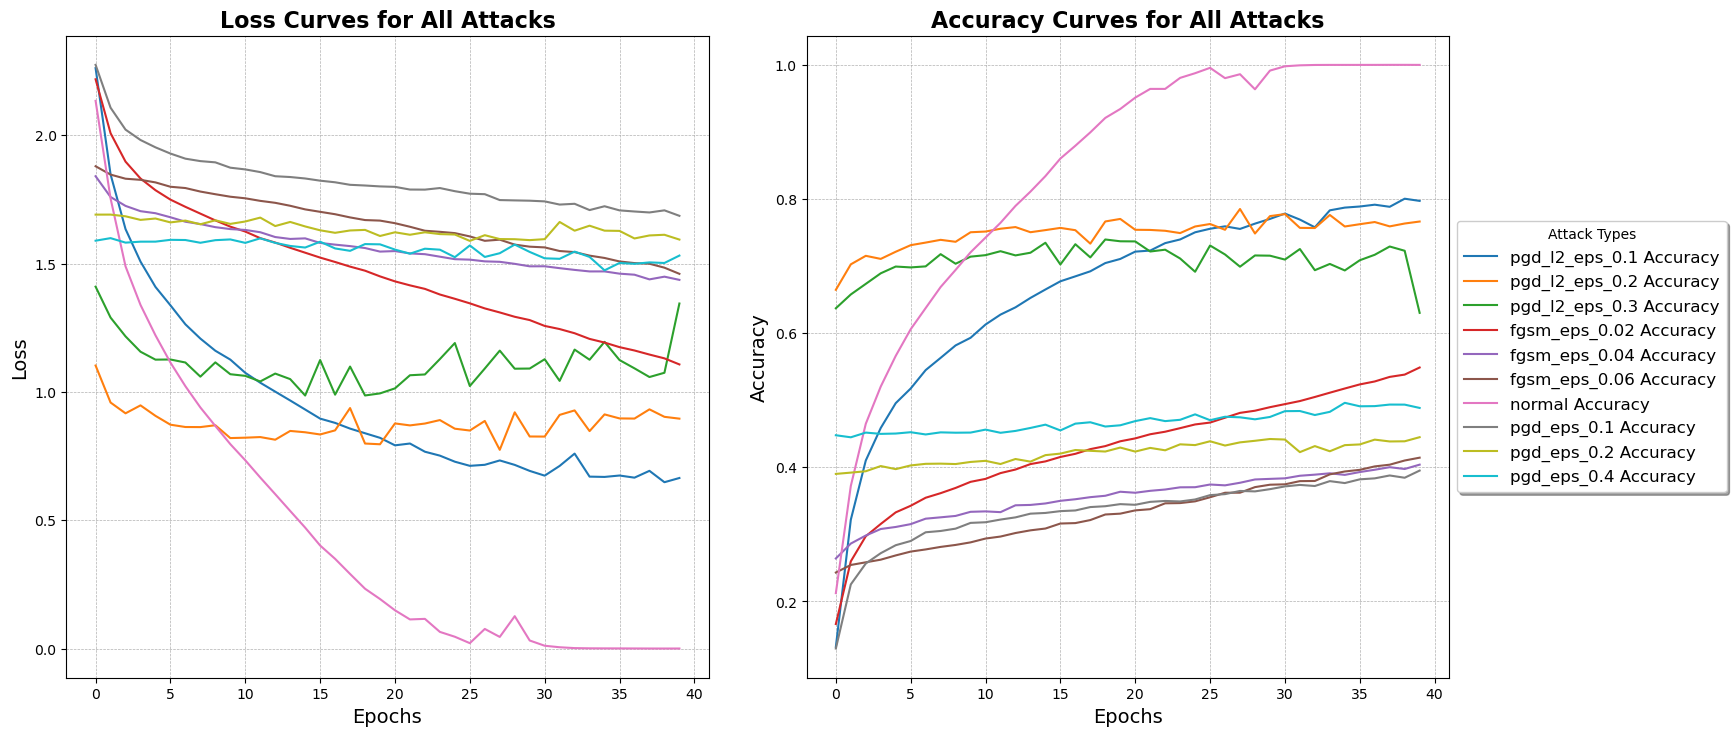

In [16]:
##################################################################################
# Loading of data
##################################################################################
directory = '/Users/benjamin/Documents/GitHub/IAProject/outputs/Classic/'
classic_data = load_attack_results(directory)

##################################################################################
# Plotting of curves
##################################################################################
plot_learning_curves(classic_data)

      Attack Type  Test Accuracy  Test Precision  Test Recall  Test F1 Score
0  pgd_l2_eps_0.1         0.4132        0.446480       0.4132       0.423454
1  pgd_l2_eps_0.2         0.3815        0.390981       0.3815       0.382742
2  pgd_l2_eps_0.3         0.3223        0.336661       0.3223       0.324410
3   fgsm_eps_0.02         0.2924        0.295538       0.2924       0.290720
4   fgsm_eps_0.04         0.1779        0.166789       0.1779       0.170685
5   fgsm_eps_0.06         0.1974        0.176964       0.1974       0.179718
6          normal         0.6844        0.686510       0.6844       0.684789
7     pgd_eps_0.1         0.2041        0.224415       0.2041       0.200578
8     pgd_eps_0.2         0.2093        0.210056       0.2093       0.208373
9     pgd_eps_0.4         0.1964        0.190586       0.1964       0.191700


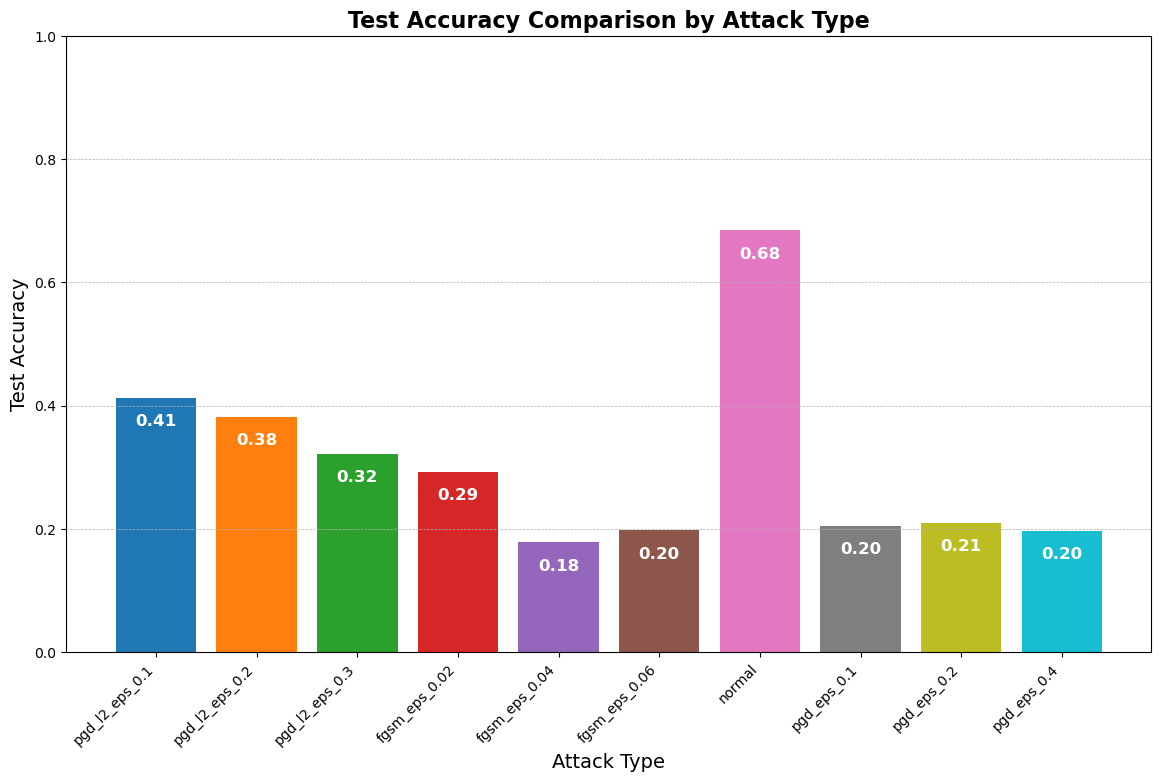

In [17]:
##################################################################################
# Metrics and plotting accuracies
##################################################################################
summary_metrics_with_accuracy_plot(classic_data)

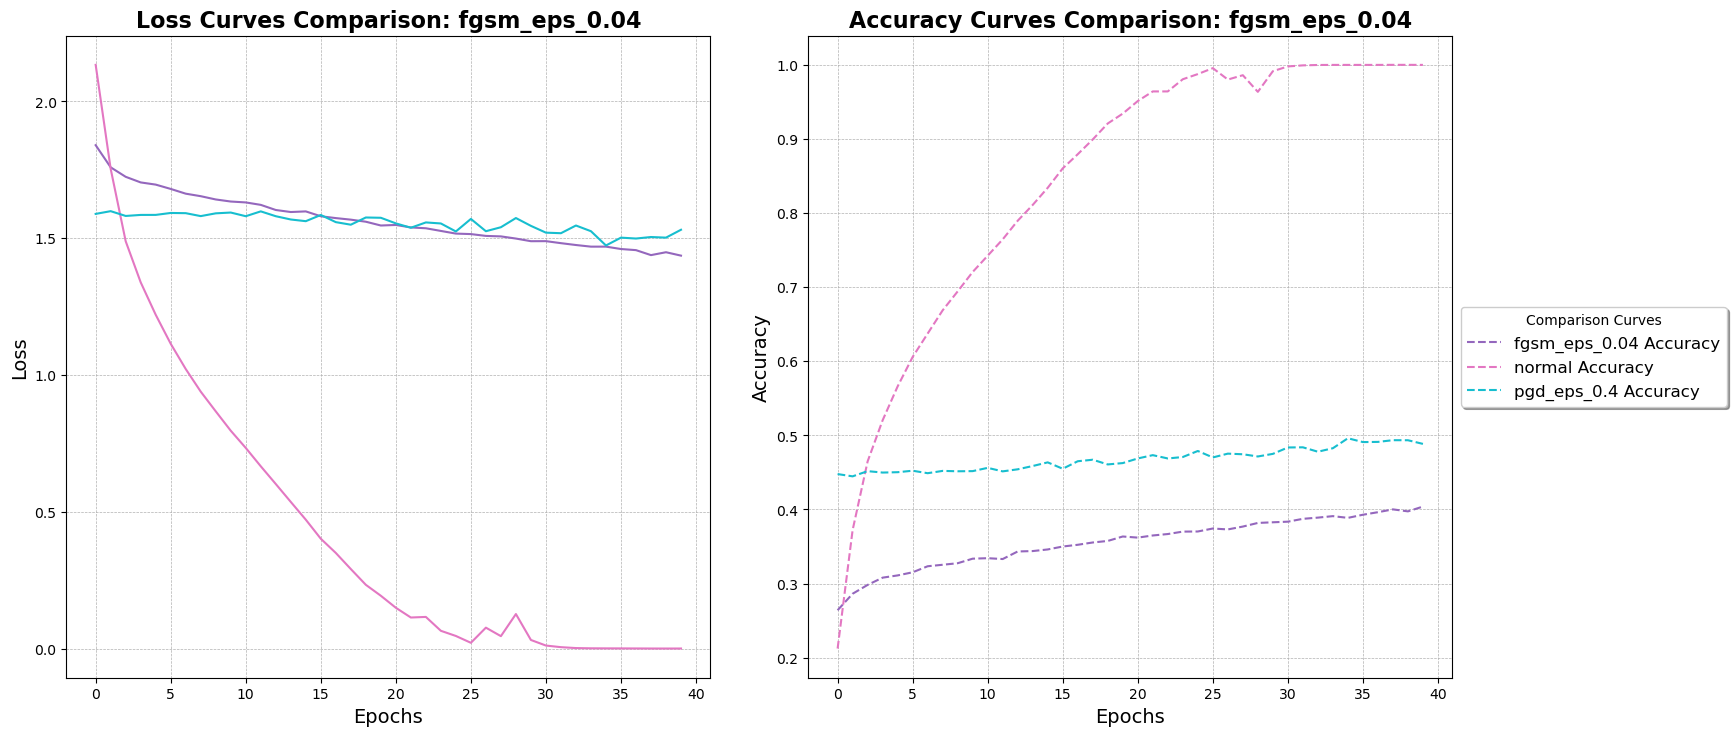

In [18]:
##################################################################################
# Plotting of curves
##################################################################################
main_attack = 'fgsm_eps_0.04'
normal_model = 'normal'
optional_attack = 'pgd_eps_0.4'

plot_learning_comparison(classic_data, main_attack= main_attack, compare_with=normal_model, optional_attack=optional_attack)

## Temps d'exécution des attaques

L'efficacité des attaques peut également être analysée sous le prisme du temps d'execution. Les attaques plus rapides peuvent être préférées dans des environnements où le temps est critique, tandis que les attaques plus lentes peuvent être justifiées si elles sont plus efficaces en termes de dégradation des performances.

De manière générale, il apparaît que les attaquent augmentent considérablement les temps d'execution, en particulier les attaques PGD .

- **FGSM** :
        - Accuracy : chute significative de l’accuracy (de 0.2924 à 0.1779) à mesure que l’epsilon augmente pour un temps d'exécution relativement faible (~528 ms pour toutes les variantes).
        - FGSM est efficace en termes de dégradation de la performance (surtout avec des epsilons élevés) et a un faible coût en temps.
- **PGD** :
        - Accuracy : très faible accuracy (0.2041 à 0.1964) pour tous les epsilons, comparable à FGSM.
        - Temps d’exécution : temps d’exécution élevé (2151 ms à 2637 ms), le rendant moins efficace en termes de compromis accuracy/temps.
        - PGD est très coûteux en temps et ne surpasse pas FGSM en termes de dégradation des performances.
- **PGD-L2** :
        - Accuracy : meilleure accuracy que FGSM et PGD pour les faibles epsilons (0.4132 pour epsilon=0.1), mais elle chute rapidement (0.3223 pour epsilon=0.3).
        - Temps d’exécution : temps élevé (~2183 à 2498 ms), proche de PGD.
        - PGD-L2 offre un compromis légèrement meilleur qu’un PGD classique, mais reste coûteux comparé à FGSM.

**En conclusion, les attaques peuvent être classées selon le compromis entre l'accuracy et le temps avec une prime aux attaques FGSM qui sont le meilleur compromis entre efficacité et vitesse.
Toutefois, les attaques PGD_L2 peuvent être préférées pour des attaques plus précises et réalistes, bien que plus coûteuses en temps.**


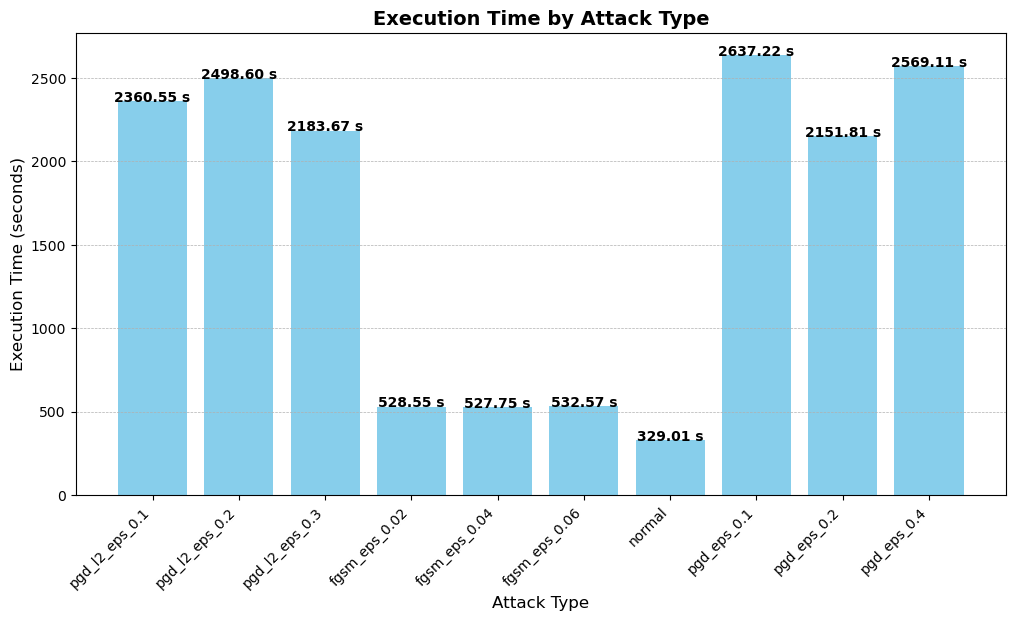

In [19]:
##################################################################################
# Plotting execution times
##################################################################################
directory = '/Users/benjamin/Documents/GitHub/IAProject/outputs/Classic'
classic_exec_times = load_execution_times(directory)

plot_execution_times(classic_exec_times)

      Attack Type  Test Accuracy  Execution Time  \
0  pgd_l2_eps_0.1         0.4132     2360.546261   
1  pgd_l2_eps_0.2         0.3815     2498.597363   
2  pgd_l2_eps_0.3         0.3223     2183.673659   
3   fgsm_eps_0.02         0.2924      528.549709   
4   fgsm_eps_0.04         0.1779      527.745592   
5   fgsm_eps_0.06         0.1974      532.565848   
6          normal         0.6844      329.009799   
7     pgd_eps_0.1         0.2041     2637.216105   
8     pgd_eps_0.2         0.2093     2151.806076   
9     pgd_eps_0.4         0.1964     2569.112864   

   Efficiency Ratio (1-Accuracy)/Time  
0                            0.000249  
1                            0.000248  
2                            0.000310  
3                            0.001339  
4                            0.001558  
5                            0.001507  
6                            0.000959  
7                            0.000302  
8                            0.000367  
9                          

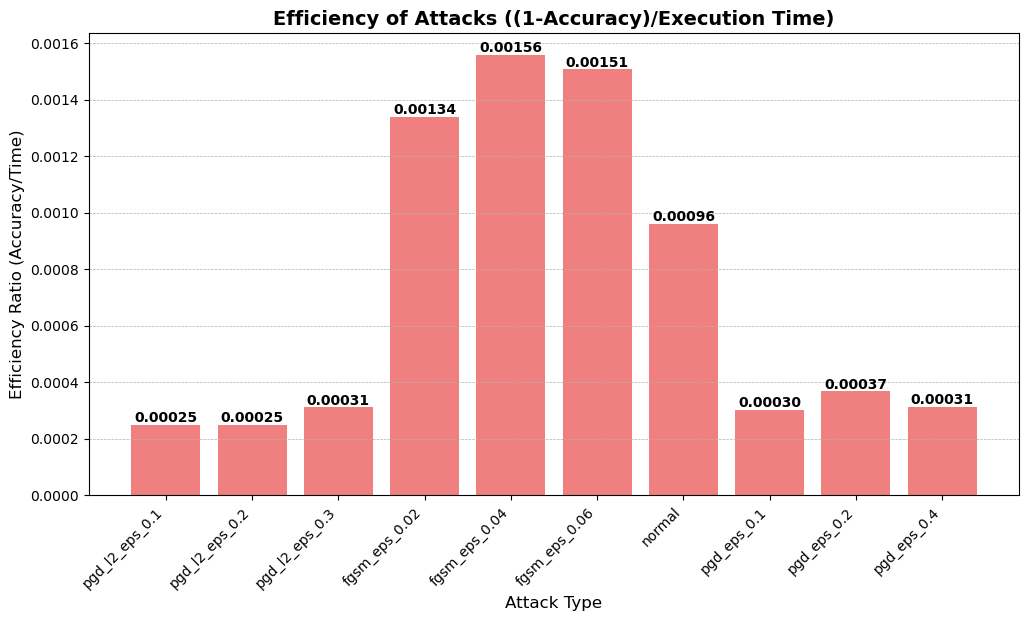

In [20]:
##################################################################################
# Analysing efficiency - tradeoff between accuracy and time  
##################################################################################
analyze_efficiency(classic_data, classic_exec_times)

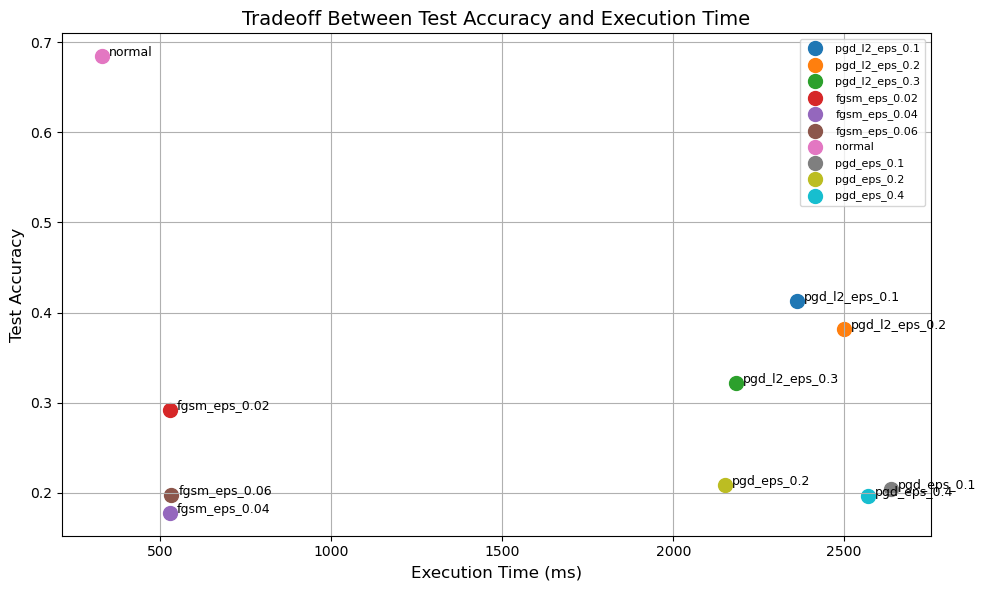

In [21]:
plot_accuracy_vs_execution_time(classic_data, classic_exec_times)

# Analyse des performances du modèle Lipschitz
---------------------------------------------------------------

Les performances du modèle sont les suivantes :

| Attack Type      | Accuracy | Precision | Recall | F1 Score |
|------------------|----------|-----------|--------|----------|
| pgd\_l2\_eps\_0.1 | 0.5919   | 0.605126  | 0.5919 | 0.593308 |
| pgd\_l2\_eps\_0.2 | 0.5123   | 0.522890  | 0.5123 | 0.514202 |
| pgd\_l2\_eps\_0.3 | 0.4419   | 0.443693  | 0.4419 | 0.439225 |
| fgsm\_eps\_0.02   | 0.3501   | 0.339699  | 0.3501 | 0.339697 |
| fgsm\_eps\_0.04   | 0.2228   | 0.208919  | 0.2228 | 0.213321 |
| fgsm\_eps\_0.06   | 0.2782   | 0.270973  | 0.2782 | 0.272173 |
| normal           | 0.6675   | 0.676193  | 0.6675 | 0.665547 |
| pgd\_eps\_0.1     | 0.3202   | 0.314448  | 0.3202 | 0.306353 |
| pgd\_eps\_0.2     | 0.2763   | 0.279032  | 0.2763 | 0.272368 |
| pgd\_eps\_0.4     | 0.2389   | 0.239922  | 0.2389 | 0.236139 |

Les conclusions sont globalement identiques que sur le modèle classique, mais avec une meilleure résilience aux attaques adversariales. Le modèle Lipschitz est plus robuste face aux attaques adversariales, en particulier pour des epsilons faibles à modérés. Cependant, pour des perturbations très importantes (epsilon élevé), même le modèle Lipschitz voit sa performance fortement dégradée, bien qu’il reste meilleur que le modèle classique.

Il sera interessant dans la suite de l'analyse de comparer les performances des deux modèles

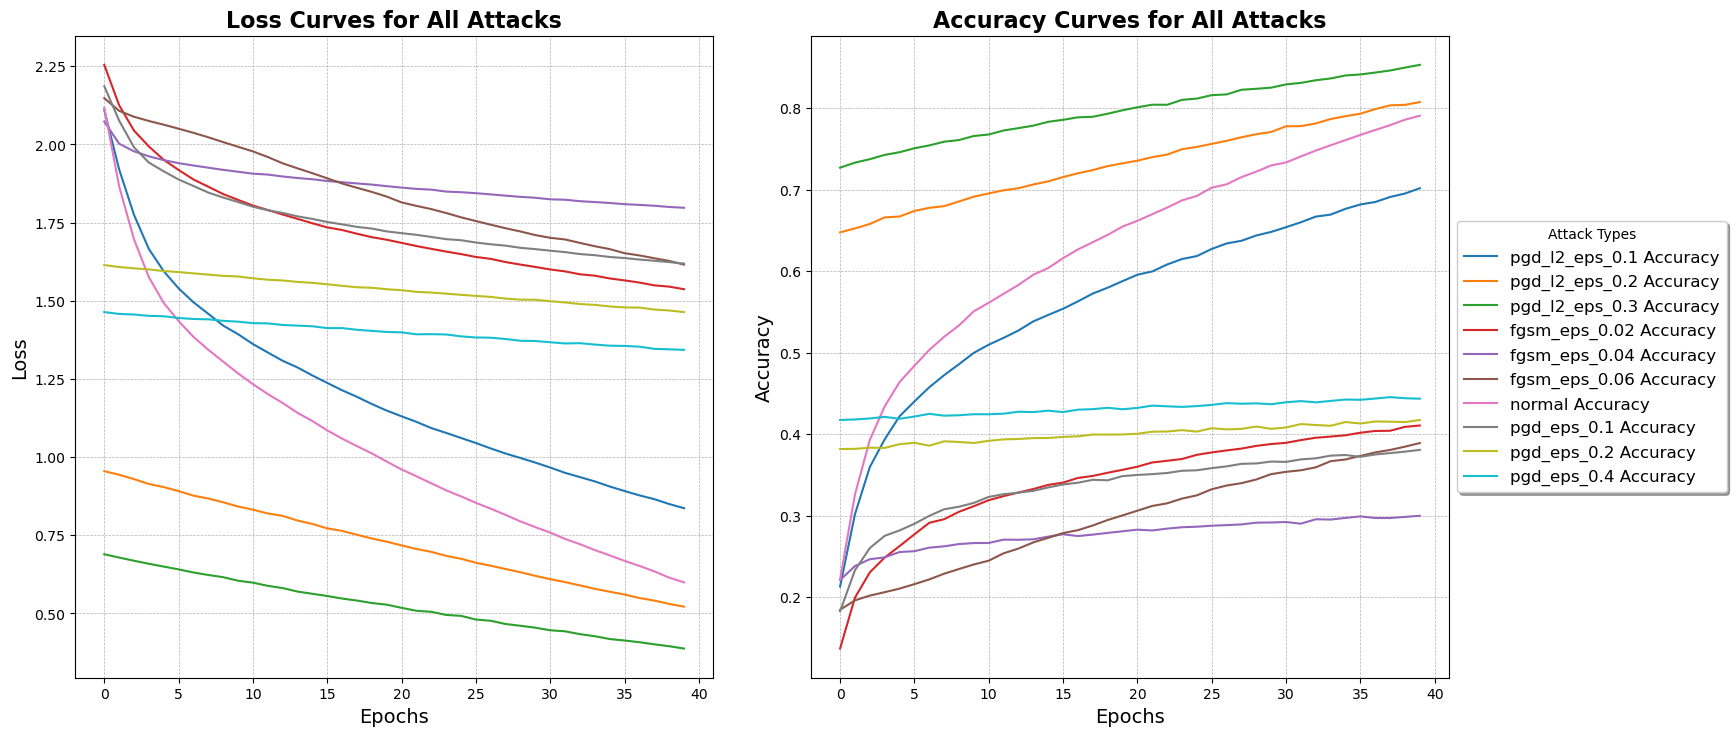

In [23]:
##################################################################################
# Loading of data
##################################################################################
directory = '/Users/benjamin/Documents/GitHub/IAProject/outputs/Lipschitz/'
lipschitz_data = load_attack_results(directory)

##################################################################################
# Plotting of curves
##################################################################################
plot_learning_curves(lipschitz_data)

      Attack Type  Test Accuracy  Test Precision  Test Recall  Test F1 Score
0  pgd_l2_eps_0.1         0.5919        0.605126       0.5919       0.593308
1  pgd_l2_eps_0.2         0.5123        0.522890       0.5123       0.514202
2  pgd_l2_eps_0.3         0.4419        0.443693       0.4419       0.439225
3   fgsm_eps_0.02         0.3501        0.339699       0.3501       0.339697
4   fgsm_eps_0.04         0.2228        0.208919       0.2228       0.213321
5   fgsm_eps_0.06         0.2782        0.270973       0.2782       0.272173
6          normal         0.6675        0.676193       0.6675       0.665547
7     pgd_eps_0.1         0.3202        0.314448       0.3202       0.306353
8     pgd_eps_0.2         0.2763        0.279032       0.2763       0.272368
9     pgd_eps_0.4         0.2389        0.239922       0.2389       0.236139


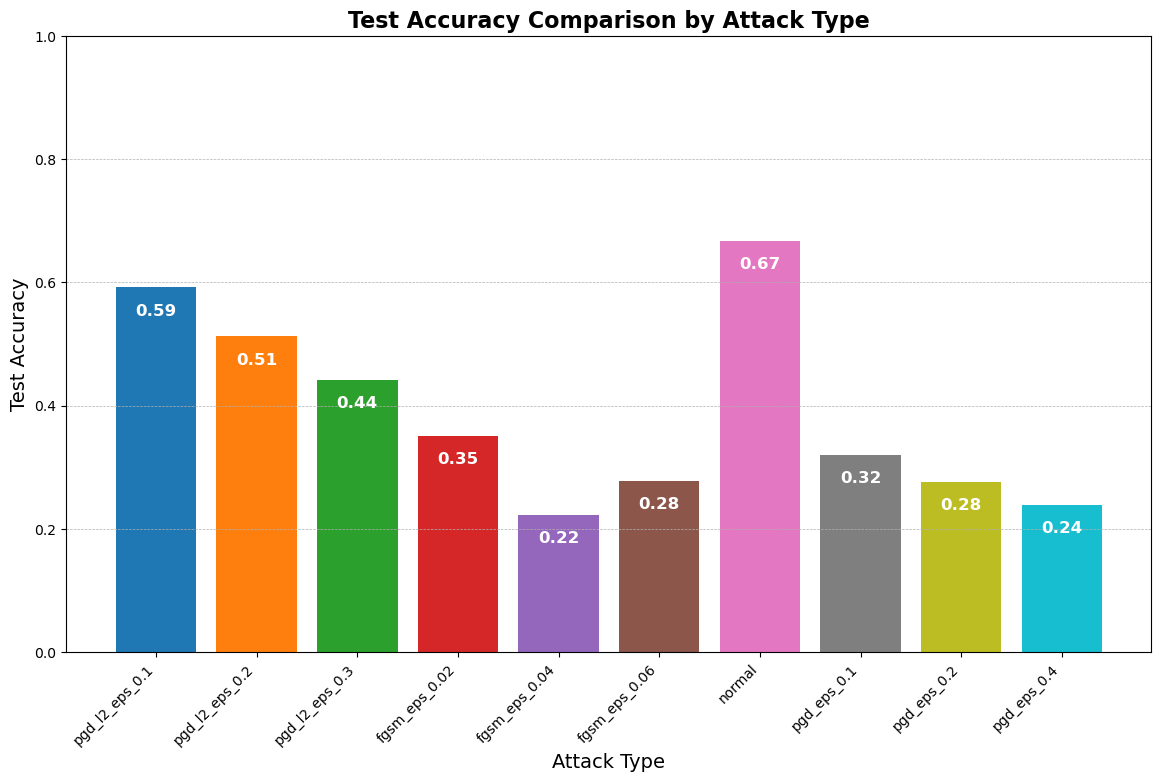

In [24]:
##################################################################################
# Metrics and plotting accuracies
##################################################################################
summary_metrics_with_accuracy_plot(lipschitz_data)

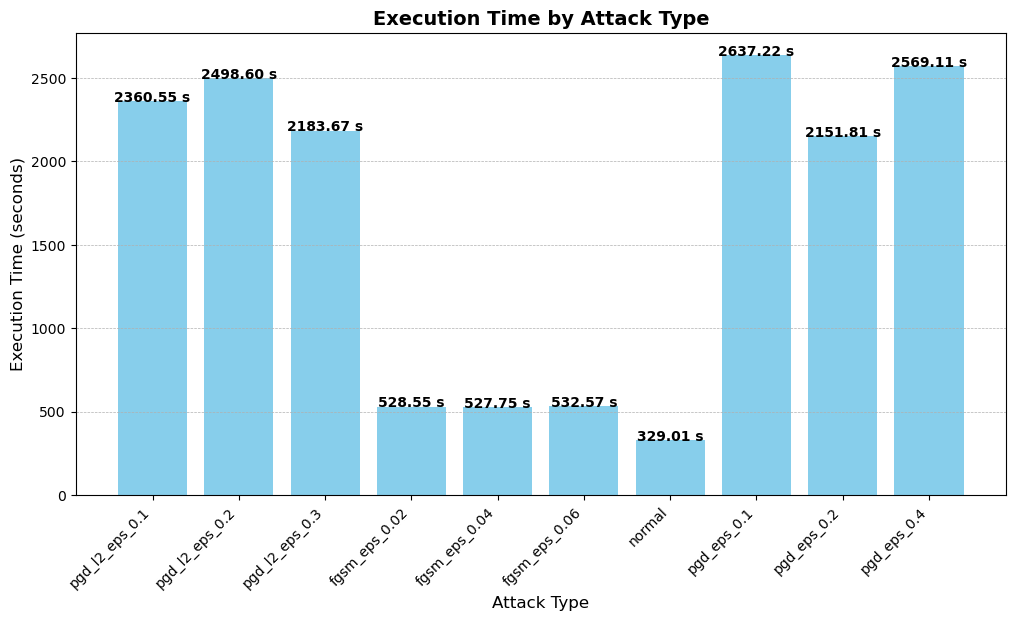

In [25]:
##################################################################################
# Plotting execution times
##################################################################################
directory = '/Users/benjamin/Documents/GitHub/IAProject/outputs/Classic'
lipschitz_exec_times = load_execution_times(directory)

plot_execution_times(lipschitz_exec_times)

# Comparaison des performances des deux modèles
---------------------------------------------------------------

Le graphique ci-dessous présente une comparaison de l’accuracy de test entre deux modèles (le Classic Model en bleu et le Lipschitz Model en rouge) pour différents types d’attaques adversariales.

**1. Résilience du modèle Lipschitz :**
	- Le modèle Lipschitz a généralement une meilleure accuracy que le modèle classique pour presque toutes les attaques adversariales.
	- Cela suggère que l’ajout de contraintes de Lipschitz contribue à une plus grande robustesse face aux perturbations adversariales.

**2. Impact des attaques adversariales :**
	- Pour pgd_l2_eps_0.1 et pgd_l2_eps_0.2, le modèle Lipschitz conserve une performance significativement plus élevée que le modèle classique.
	- À mesure que l’epsilon augmente (par exemple, pour pgd_l2_eps_0.3), les deux modèles voient leur accuracy diminuer, mais le modèle Lipschitz reste supérieur.

**3. Performance sur données normales :**
	- Sur les données normales, les deux modèles atteignent des performances très proches, ce qui indique que la régularisation Lipschitz n’affecte pas négativement la performance du modèle en l’absence d’attaques adversariales.

**4. Performances pour FGSM :**
	- Pour FGSM (epsilon 0.02, 0.04, et 0.06), le modèle Lipschitz dépasse également le modèle classique, mais les deux modèles subissent une dégradation importante à epsilon élevé (surtout pour fgsm_eps_0.04 et fgsm_eps_0.06).
	- Cela confirme que FGSM avec un epsilon élevé est une attaque destructrice, mais que le modèle Lipschitz reste plus résilient.

**5. Performances pour PGD :**
	- Pour les attaques PGD (epsilon 0.1, 0.2, et 0.4), la même tendance se maintient : le modèle Lipschitz conserve une meilleure accuracy, bien que les deux modèles voient leurs performances diminuer avec des epsilons croissants.

**Conclusion Générale :**
- Le modèle Lipschitz est clairement plus robuste aux attaques adversariales que le modèle classique, en particulier pour des epsilons faibles à modérés.
- Cependant, pour des perturbations très importantes (epsilon élevé), même le modèle Lipschitz voit sa performance fortement dégradée, bien qu’il reste meilleur que le modèle classique.
- La contrainte Lipschitz est donc une stratégie efficace pour renforcer la robustesse aux attaques adversariales sans nuire à la performance sur des données normales.

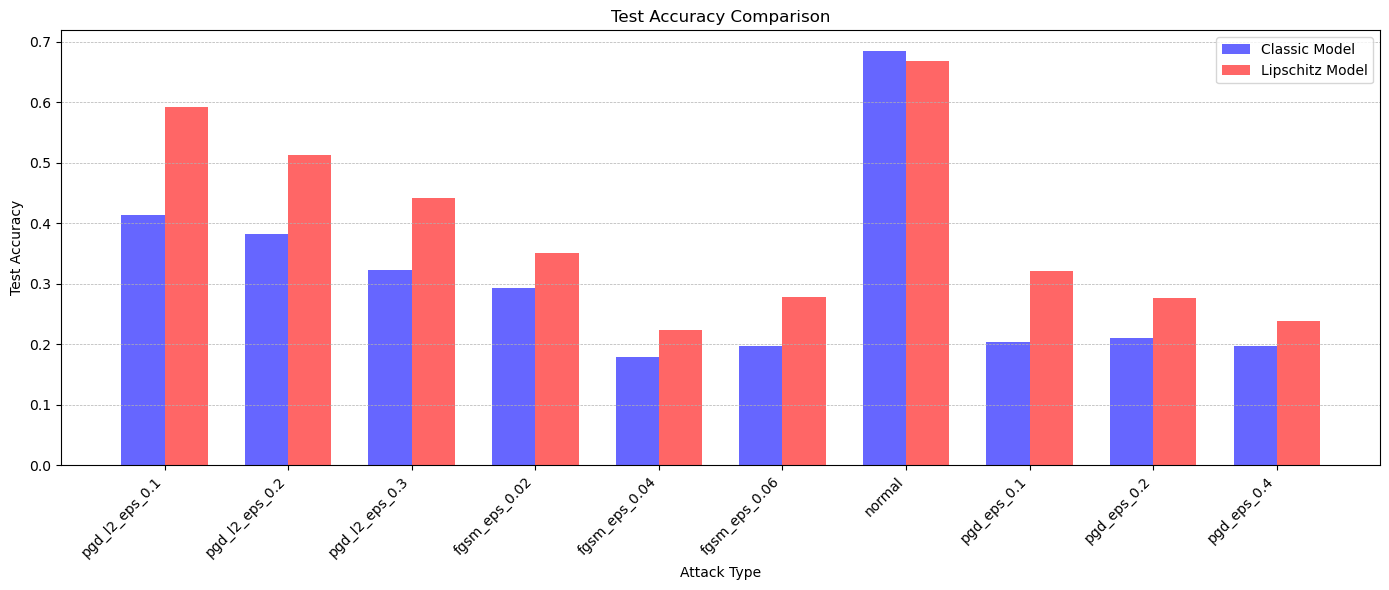

In [33]:
compare_models_accuracy_execution_time(classic_data, lipschitz_data)

# Analyse des modèles avec des données bruitées
---------------------------------------------------------------

A COMPLETER

In [42]:

\text{Inverse Efficiency Ratio} = \frac{1 - \text{Test Accuracy}}{\text{Execution Time}}


Valeurs élevées : Un Inverse Efficiency Ratio élevé signifie que l’attaque a fortement réduit l’accuracy du modèle (valeur proche de 0) tout en ayant un temps d’exécution court.
	•	Valeurs faibles : Un ratio faible indiquerait soit que l’accuracy n’est pas beaucoup affectée (l’attaque est inefficace), soit que le temps d’exécution est long, ce qui rend l’attaque coûteuse.


GSM génère des perturbations en une seule étape, en utilisant un calcul unique du gradient de la fonction de perte par rapport à l’entrée. Elle déplace chaque pixel ou caractéristique d’entrée dans la direction du gradient, avec une intensité définie par le paramètre epsilon (\epsilon), qui contrôle l’ampleur de la perturbation.
	•	Cette approche en une seule étape, également appelée “one-step attack”, fait de FGSM une attaque extrêmement rapide car elle ne nécessite pas de multiples calculs d’optimisation.

Carlini-Wagner, en revanche, est beaucoup plus complexe : elle résout un problème d’optimisation dans lequel elle minimise la perturbation ajoutée tout en maximisant la probabilité que le modèle se trompe.
	•	Cette attaque est itérative et affine progressivement la perturbation pour qu’elle soit la plus discrète possible tout en réussissant à tromper le modèle. Cela nécessite plusieurs passes et calculs répétés, ce qui augmente considérablement le temps de calcul.

3. Objectifs : Rapidité et efficacité brute vs. subtilité et efficacité ciblée

	•	FGSM est conçue pour une efficacité brute : elle maximise la perte du modèle en une seule étape, ce qui permet de tromper rapidement le modèle. Cela peut être suffisant pour diminuer drastiquement la performance, mais les perturbations sont souvent plus grandes et plus visibles.
	•	Carlini-Wagner, quant à elle, vise la subtilité : son optimisation en plusieurs étapes trouve une perturbation minimale (et donc difficilement détectable) qui est suffisante pour induire en erreur le modèle. Cela peut rendre l’attaque plus puissante et plus difficile à détecter, mais au prix d’un temps de calcul plus long.

SyntaxError: unexpected character after line continuation character (2249992982.py, line 1)